In [105]:
# Librerias generales
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

In [106]:
data = pd.read_csv('train.csv')

### Limpieza y preprocesamiento de datos

In [107]:
# Combinar keyword y location en un solo campo
data['features'] = data['keyword'].fillna('') + ' ' + data['location'].fillna('') + ' ' + data['text']

# Convertir a minúsculas
data['text'] = data['text'].str.lower()

# Quitar caracteres especiales, URL y números
data['text'] = data['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
data['text'] = data['text'].apply(lambda x: re.sub(r'http\S+', '', x))
data['text'] = data['text'].apply(lambda x: re.sub(r'\d+', '', x))

# Quitar stopwords
stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))


In [108]:
###frecuencia de las palabras
# Dividir los datos en tweets de desastres y no desastres
disaster_tweets = data[data['target'] == 1]['text']
non_disaster_tweets = data[data['target'] == 0]['text']

# Tokenización y conteo de palabras
disaster_word_counts = Counter(' '.join(disaster_tweets).split())
non_disaster_word_counts = Counter(' '.join(non_disaster_tweets).split())

In [164]:
disaster_tweets

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                 utckm volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 3271, dtype: object

### Analisis exploratorio

In [109]:
# Palabras más comunes en tweets de desastres
disaster_common_words = disaster_word_counts.most_common(20)
print("Palabras comunes en tweets de desastres:", disaster_common_words)

Palabras comunes en tweets de desastres: [('fire', 180), ('news', 140), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('amp', 107), ('people', 105), ('killed', 93), ('like', 92), ('pm', 89), ('hiroshima', 89), ('storm', 85), ('us', 84), ('crash', 84), ('fires', 84), ('families', 81), ('train', 79), ('emergency', 76)]


In [110]:
# Palabras más comunes en tweets no desastres
non_disaster_common_words = non_disaster_word_counts.most_common(20)
print("Palabras comunes en tweets no desastres:", non_disaster_common_words)

Palabras comunes en tweets no desastres: [('like', 253), ('im', 248), ('amp', 193), ('new', 170), ('get', 163), ('dont', 154), ('one', 128), ('body', 113), ('via', 99), ('would', 97), ('video', 96), ('people', 91), ('love', 90), ('cant', 86), ('us', 86), ('time', 85), ('know', 85), ('back', 84), ('got', 83), ('see', 82)]


Parece que explorar bigramas o trigramas podría ser beneficioso para capturar mejor el contexto y las relaciones entre las palabras en ambos tipos de tweets. Por ejemplo, en el contexto de desastres, las combinaciones de palabras como 'california fire', 'suicide bomber', 'train crash', y similares podrían ser indicativas de la categoría de desastres.

In [111]:
# Crear vectorizador para unigramas y bigramas
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=1000)  # Puedes ajustar el número máximo de características

# Obtener la matriz de términos de documento
X = vectorizer.fit_transform(data['text'])

# Obtener las palabras más comunes en unigramas y bigramas para cada clase
disaster_common_words = vectorizer.get_feature_names_out()
non_disaster_common_words = vectorizer.get_feature_names_out()

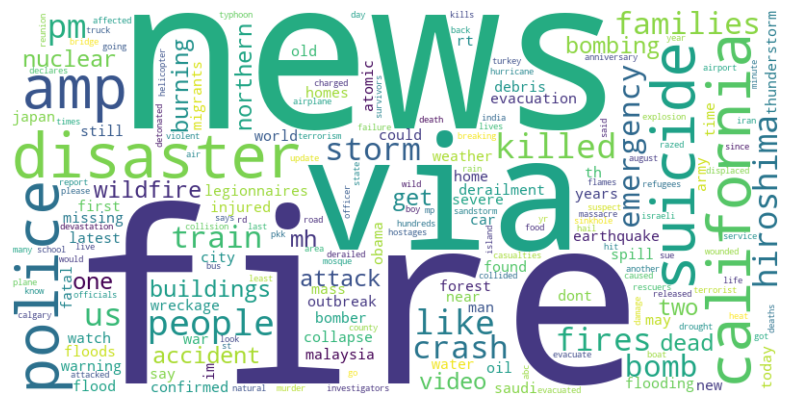

In [112]:
# Nube de palabras de desastres
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(disaster_word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

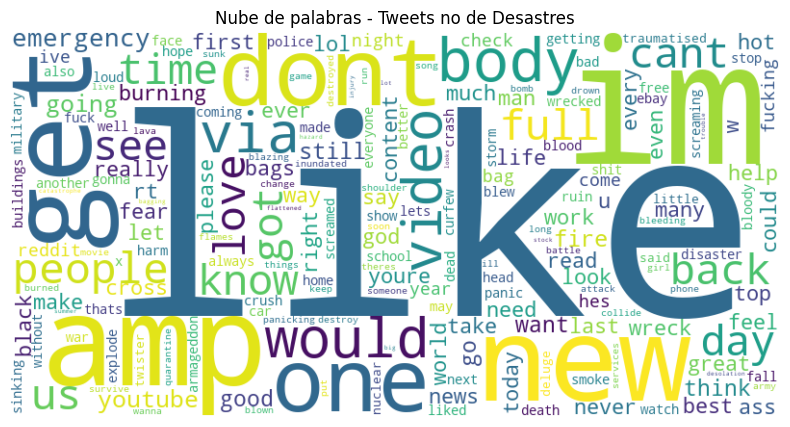

In [113]:
# Nube de palabras para tweets no desastres
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(non_disaster_word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Nube de palabras - Tweets no de Desastres')
plt.axis('off')
plt.show()

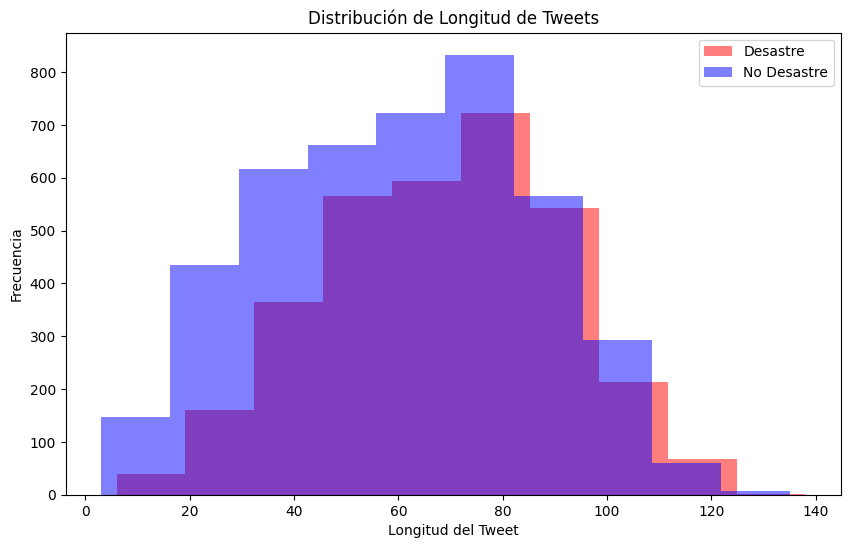

In [114]:
data['tweet_length'] = data['text'].apply(len)

plt.figure(figsize=(10, 6))
data[data['target'] == 1]['tweet_length'].plot(kind='hist', color='red', alpha=0.5, label='Desastre')
data[data['target'] == 0]['tweet_length'].plot(kind='hist', color='blue', alpha=0.5, label='No Desastre')
plt.xlabel('Longitud del Tweet')
plt.ylabel('Frecuencia')
plt.legend()
plt.title('Distribución de Longitud de Tweets')
plt.show()

Se observa que existe más información no compartida de tweets de no desastres que de desastres. Esto puede tener un impacto en la capacidad del modelo para generalizar y hacer predicciones precisas.

In [115]:
common_words = set(disaster_word_counts.keys()) & set(non_disaster_word_counts.keys())
print("Palabras comunes en ambas categorías:", common_words)

Palabras comunes en ambas categorías: {'calm', 'reveals', 'zippednews', 'imported', 'china', 'fuck', 'hillary', 'alarms', 'nobody', 'asked', 'dubstep', 'hurry', 'effect', 'gbbo', 'lies', 'arent', 'politics', 'price', 'talking', 'otherwise', 'stephen', 'cause', 'mall', 'interest', 'sell', 'drowning', 'moral', 'unavoidable', 'jet', 'group', 'community', 'brief', 'rid', 'challenge', 'mistake', 'thoughts', 'share', 'denver', 'oth', 'nursing', 'steel', 'prefer', 'heartwarming', 'avoid', 'flames', 'sunset', 'options', 'shame', 'homeless', 'survival', 'brought', 'nuggets', 'blacklivesmatter', 'fr', 'assistance', 'rules', 'smaug', 'sit', 'fighters', 'recycling', 'wants', 'dumb', 'panic', 'asap', 'mad', 'cs', 'hitting', 'hurt', 'western', 'hills', 'chills', 'realtime', 'burned', 'total', 'playlist', 'took', 'evacuation', 'maybe', 'security', 'officer', 'long', 'crew', 'rate', 'appreciated', 'ay', 'full', 'particularly', 'address', 'ban', 'subject', 'society', 'headlines', 'class', 'join', 'exac

### Modelo de prediccion

In [158]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=41)

# Crear el modelo con TF-IDF y Naive Bayes
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000000)),  # Puedes ajustar el número máximo de características
    ('clf', MultinomialNB()),
])

In [159]:
# Entrenar el modelo
text_clf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = text_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       867
           1       0.86      0.70      0.77       656

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.83      0.82      0.82      1523



In [160]:
# Calcular precisión
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.8220617202889035


El modelo tiene una precisión razonable en general, pero parece tener un mejor rendimiento en la clasificación de tweets no desastres (clase 0) en comparación con los tweets de desastres (clase 1) pues se observa una diferencia de presición de 0.06. El recall es más alto para la clase 0, lo que sugiere que el modelo tiene más éxito en identificar correctamente los tweets no desastres.

In [161]:
##funcion para clasificar
def classify_tweet(tweet):
    prediction = text_clf.predict([tweet])
    if prediction[0] == 1:
        return "Desastre"
    else:
        return "No desastre"

In [169]:
# Ejemplo de uso 1
tweet_to_classify = "Incendio en el centro de la ciudad"
classification = classify_tweet(tweet_to_classify)
print("Clasificación:", classification)

Clasificación: Desastre


In [168]:
# Ejemplo de uso 2
tweet_to_classify = "Arcoiris y colores"
classification = classify_tweet(tweet_to_classify)
print("Clasificación:", classification)

Clasificación: No desastre
